In [2]:
%load_ext autoreload
#nice magic to reload modules without kernelrestart --> important: it is maybee a bit bugy
%autoreload 2

import sys
%aimport -sys
import os
%aimport -os
print('Current working directory:', os.getcwd())

import numpy as np
%aimport -numpy
from timeit import default_timer as timer
%aimport -default_timer
import matplotlib.pyplot as plt
%aimport -matplotlib.pyplot
%matplotlib notebook
# or use "inline" instead
from PIL import Image
%aimport -Image
#%aimport

path_to_academia_ai = os.path.join(os.pardir, os.pardir)
if path_to_academia_ai not in sys.path:
    sys.path.append(path_to_academia_ai)
import academia_ai as ai
import academia_ai.preprocessing as preprocessing

Current working directory: /Users/Dino/Dropbox/Academia2016/academia_AI/academia_ai/examples
Reloaded leafs!
Loaded preprocessing!
Reloaded plotting!


# How to use Preprocessing:

In [9]:
#lays all images ontop of each other --> the result image can be used to determine the interesting area of the
#pictures and determine the cutting borders
path = '/Users/Dino/Desktop/1'
maximum = find_overlap(path)
plt.imshow(maximum)

In [6]:
#create individual images.npy and collects them to leafs/data/...
root_path = '/Users/Dino/Documents/Academia/2016_ArtificialIntelligence/Data-Leaf-Coded/'
save_path = '/Users/Dino/Dropbox/Academia2016/academia_AI/academia_ai/leafs/data/'
preprocessing.collectData(root_path, save_path, cfactor = 20, overwrite = False)
# die resultierende Grösse ist 2000 / cfactor 

In [4]:
#create a training and a testing list
path = '/Users/Dino/Dropbox/Academia2016/academia_AI/academia_ai/leafs/data/80x80'
data = preprocessing.createTrainingAndTestingList(path, shuffle = False)
trainset = data[0]
testset = data[1]
#preprocessing.normalize(trainset)
#preprocessing.normalize(testset)

#take from training and testing only the matrixes, not the whole object leaf
training_images = [np.array(leaf.image) for leaf in trainset]
training_solutions = [preprocessing.desired_output(leaf.label) for leaf in trainset]
test_images = [np.array(leaf.image) for leaf in testset]
test_solutions = [preprocessing.desired_output(leaf.label) for leaf in testset]

<IPython.core.display.Javascript object>


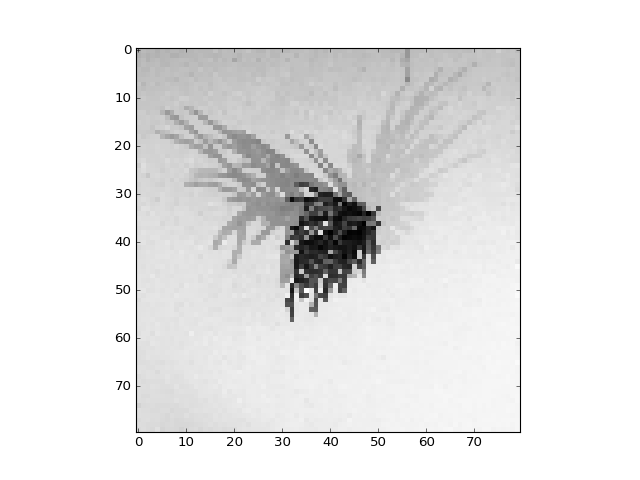

Shape of savedstuff: (882, 80, 80)


In [5]:
#test if the saved thing is useful
plt.imshow(test_images[550], interpolation = 'none', cmap ='Greys')
plt.colorbar
savedstuff = np.load('/Users/Dino/Dropbox/Academia2016/academia_AI/academia_ai/leafs/data/80x80/0.npy')
print('Shape of savedstuff:', savedstuff.shape)

## Only for testing! 

In [2]:
#processing images to arrays one-by-one and save inplace
root_path ='/Users/Dino/Documents/Academia/ArtificialIntelligence/Data-Leaf-Coded/AustauschFoto/0'
print('Root Path:', root_path)
print('Listing all files')

iid = 0
start = timer()
for (root, dirnames, filenames) in os.walk(root_path, topdown=True):
    for f in filenames:
        if f.endswith('.JPG'):
            #print('NR', iid, 'In root', root, 'found image', f)
            matriX = ai.preprocessing.centr_cut_compress(os.path.join(root, f), cfactor = 40)
            savepath = os.path.join(root, os.path.splitext(f)[0])
            savepath += "_50x50"
            np.save(savepath, matriX, allow_pickle=False)
            #print('And processed into', savepath+'.npy')
            iid += 1
end = timer()
print('Done in: ', end-start, 'seconds.')

Root Path: /Users/Dino/Documents/Academia/ArtificialIntelligence/Data-Leaf-Coded/AustauschFoto/0
Listing all files
Done in:  26.4955112960306 seconds.


In [5]:
# collecting all arrays into one big thing
root_path = '/Users/Dino/Documents/Academia/ArtificialIntelligence/Data-Leaf-Coded/AustauschFoto/0'

leaf_list = []
for (root, dirnames, filenames) in os.walk(root_path, topdown=True):  
    for f in filenames:
        if f.endswith('_50x50.npy'):
            if f == '_Leafs.npy':
                continue #interesting: the recurison bug
            leaf_list.append(np.load(os.path.join(root, f)))
            
print('Collected', len(leaf_list), 'leafs!')
leaf_array = np.array(leaf_list)
save_path = root_path + '/0' + '_50x50' #change the numer to the current tree which is processed
np.save(save_path, leaf_array, allow_pickle=False)
print('And saved to', save_path)

Collected 5 leafs!
And saved to /Users/Dino/Documents/Academia/ArtificialIntelligence/Data-Leaf-Coded/AustauschFoto/0/0_50x50


In [43]:
def normalize(dataset):
    '''normalize data so that over all imeges the pixels on place (x/y) have mean = 0 and are standart distributed'''
    # calculate the mean
    mean=np.zeros(dataset[0].image.shape)
    for lea in dataset:
        mean=mean+lea.image
    mean/=len(dataset)
    
    #calculating the variance
    var=np.zeros(dataset[0].image.shape)
    for lea in dataset:
        var=var+(lea.image-mean)**2
    var/=len(dataset)
    f=0.1
    var=(var-f>=0)*(var-f)+f  # caps the minimal 
    for lea in dataset:
        lea.image=(lea.image-mean)/var
    
def createTrainingAndTestingList(directory):
    l_train = [] # training set
    l_test = [] # testing set

    for n in range (7):
        matrices = np.load(os.path.join(directory, str(n)+'.npy'))

        for i in range(1): # 2x799 for training
            l_train += [ai.leafs.Leaf(i+n*1000, n, matrices[i]/255)] # Leaf(iid,label,matrix,labelstr) *labelstr deleted ..too difficult

        for i in range(1,2): # 2x100 for testing
            l_test += [ai.leafs.Leaf(i+n*1000, n, matrices[i]/255)]

    np.random.shuffle(l_train)
    np.random.shuffle(l_test)
    return([l_train,l_test])
    
        
def collectData(root_path, save_path, cfactor):
    '''processes images from root_path one-by-one and save them in same directory
    collect them try by tre, set their labels and return a training and a testing list'''
    sizeOfMatrixes = int(2000//cfactor)

    #processing images to arrays one-by-one and save inplace
    iid = 0
    for (root, dirnames, filenames) in os.walk(root_path, topdown=True):
        for f in filenames:
            if f.endswith('.JPG'):
                #print('NR', iid, 'In root', root, 'found image', f)
                savepath = os.path.join(root, os.path.splitext(f)[0])
                savepath += ('_' + str(sizeOfMatrixes) + 'x' + str(sizeOfMatrixes)) # for example + _50x50
                if(savepath):
                    matriX = preprocessing.centr_cut_compress(os.path.join(root, f), cfactor)
                    np.save(savepath, matriX, allow_pickle=False)
                #print('And processed into', savepath+'.npy')
                iid += 1
    
    # collecting all arrays from tree i into one big folder calld i.npy            
    for i in range (0,8):
        tree_path = os.path.join(root_path, str(i))
        tree_save_path = os.path.join(save_path, str(sizeOfMatrixes) + 'x' + str(sizeOfMatrixes) ,str(i))
        leaf_list = []
        for (root, dirnames, filenames) in os.walk(tree_path , topdown=True):  
            for f in filenames:
                if f.endswith('_' + str(sizeOfMatrixes) + 'x' + str(sizeOfMatrixes) + '.npy'):
                    leaf_list.append(np.load(os.path.join(root, f)))
        leaf_array = np.array(leaf_list)
        np.save(tree_save_path, leaf_array, allow_pickle=False)

def desired_output(label):
    res = -1 * np.ones((7,1,1))
    res[label, 0, 0] = +1
    return res